# How to score 0.8134 in Titanic Kaggle Challenge
------

The [Titanic challenge](https://www.kaggle.com/c/titanic/) is a competition hotest by Kaggle in which the goal is to predict the survival of a given passenger.  

This Notebook follows [this tutorial](https://www.ahmedbesbes.com/blog/kaggle-titanic-competition) for reaching a score of 0.8134. 
The tutorial has 3 main steps:
1. Data Analysis
2. Feature Engenieering
3. Modeling

## I- Data Analysis
------

In this section, we'll be doing four things.

1. Data extraction : we'll load the dataset and have a first look at it.
2. Cleaning : we'll fill in missing values.
3. Plotting : we'll create some interesting charts that'll (hopefully) spot correlations and hidden insights out of the data.
4. Assumptions : we'll formulate hypotheses from the charts.

### Data Extraction

First let's tweak the style of this notebook to have centered plots and import the necessary libraries. 

In [1]:
# have centered plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

In [2]:
# imports
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
# pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

In [3]:
# load training data
train_data = pd.read_csv('./data/train.csv')
print(f"training data has the shape: {train_data.shape}")

training data has the shape: (891, 12)


In [4]:
# pandas allows to have a statistical description of the numerical features
train_data.describe().applymap('{:,.2f}'.format)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


The count variable shows that 177 values are missing in the Age column. One solution is to fill in the null values with the median or mean age. 
- mean: average of the data set  $\frac{\sum_{i}^n(x_i)}{n}$
- median: the middle number of a data set $x_{\frac{n+1}{2}}$

In [5]:
# Use the median since it is more robust to outliers.
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

### Data Visualization

#### Gender
Let's visualize survival based on the gender.

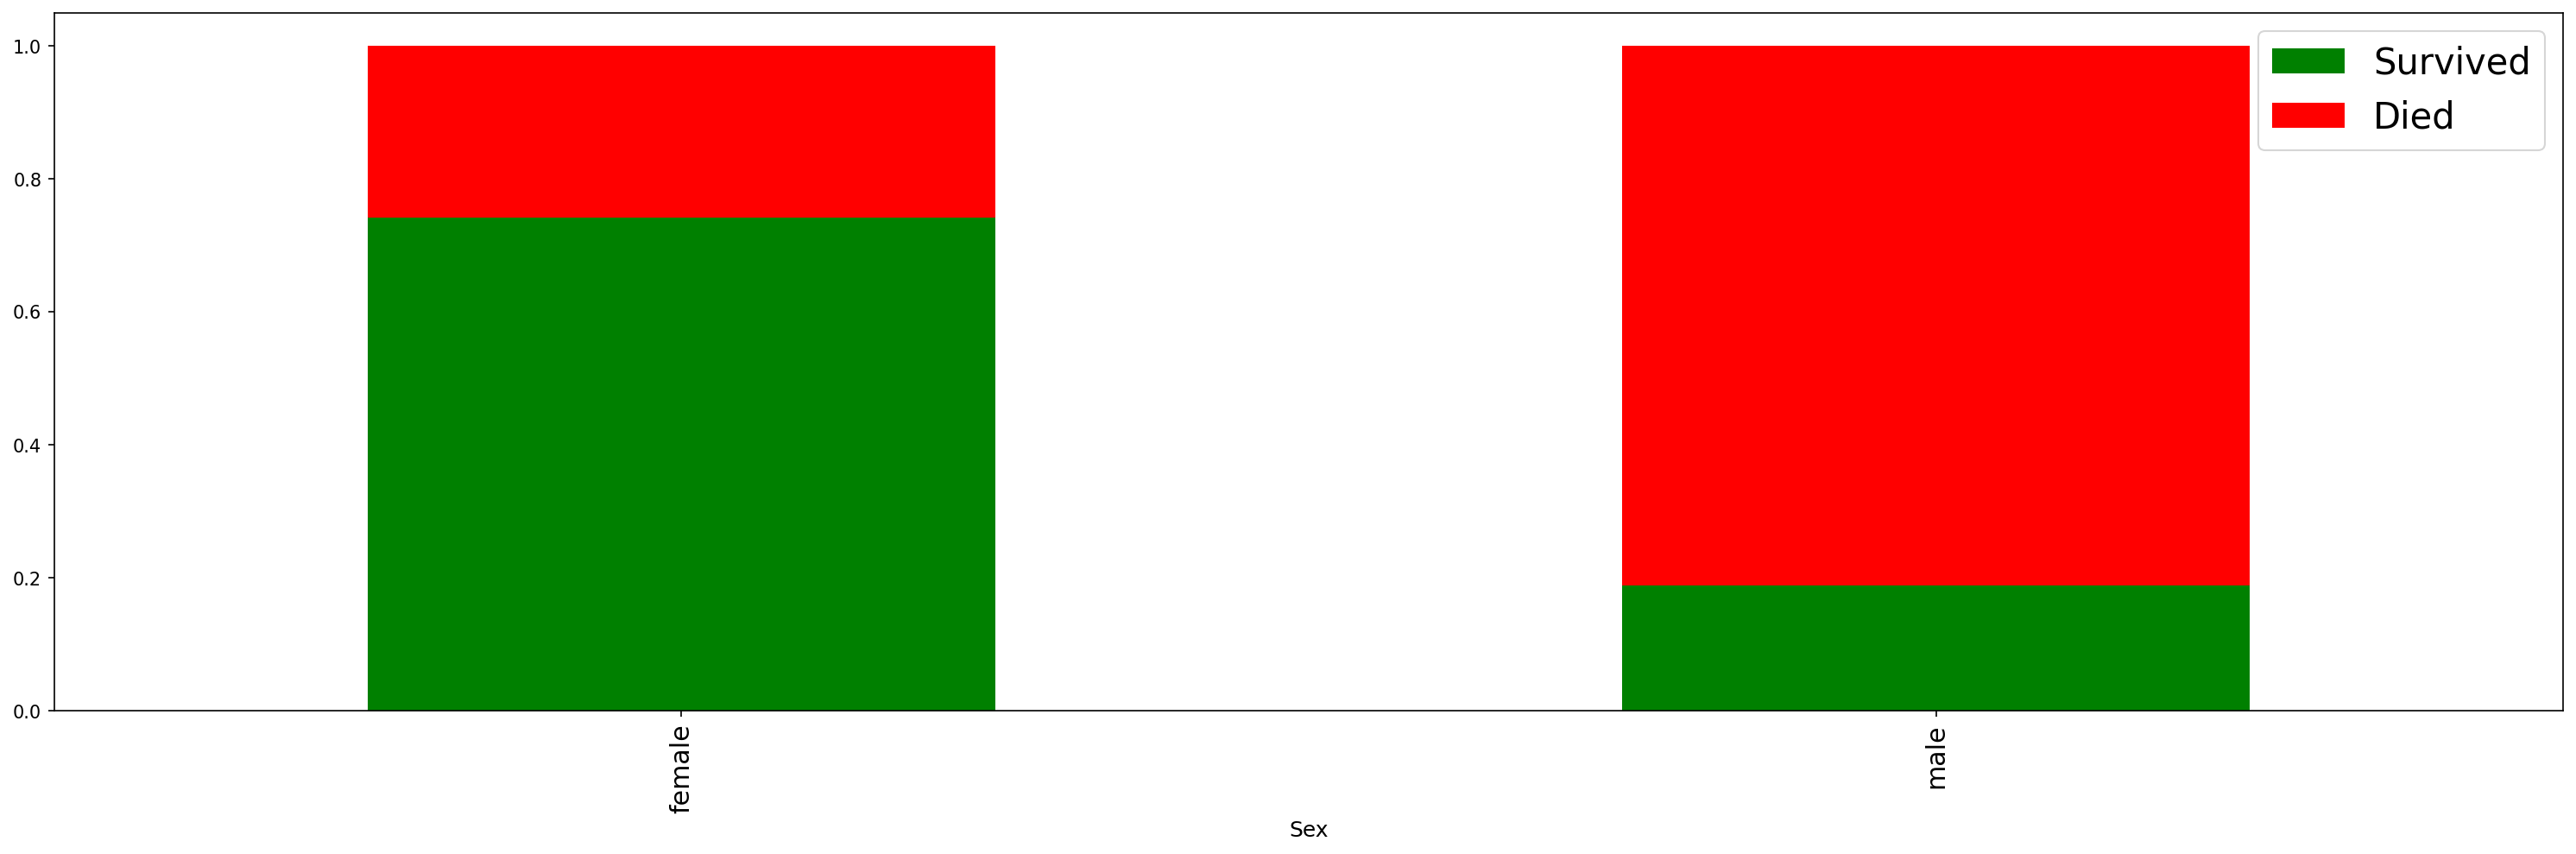

In [6]:
train_data['Died'] = 1 - train_data['Survived']
train_data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True, color={"Died": "red", "Survived": "green"});

#### Age vs Gender
Let's now correlate the survival with the age variable.

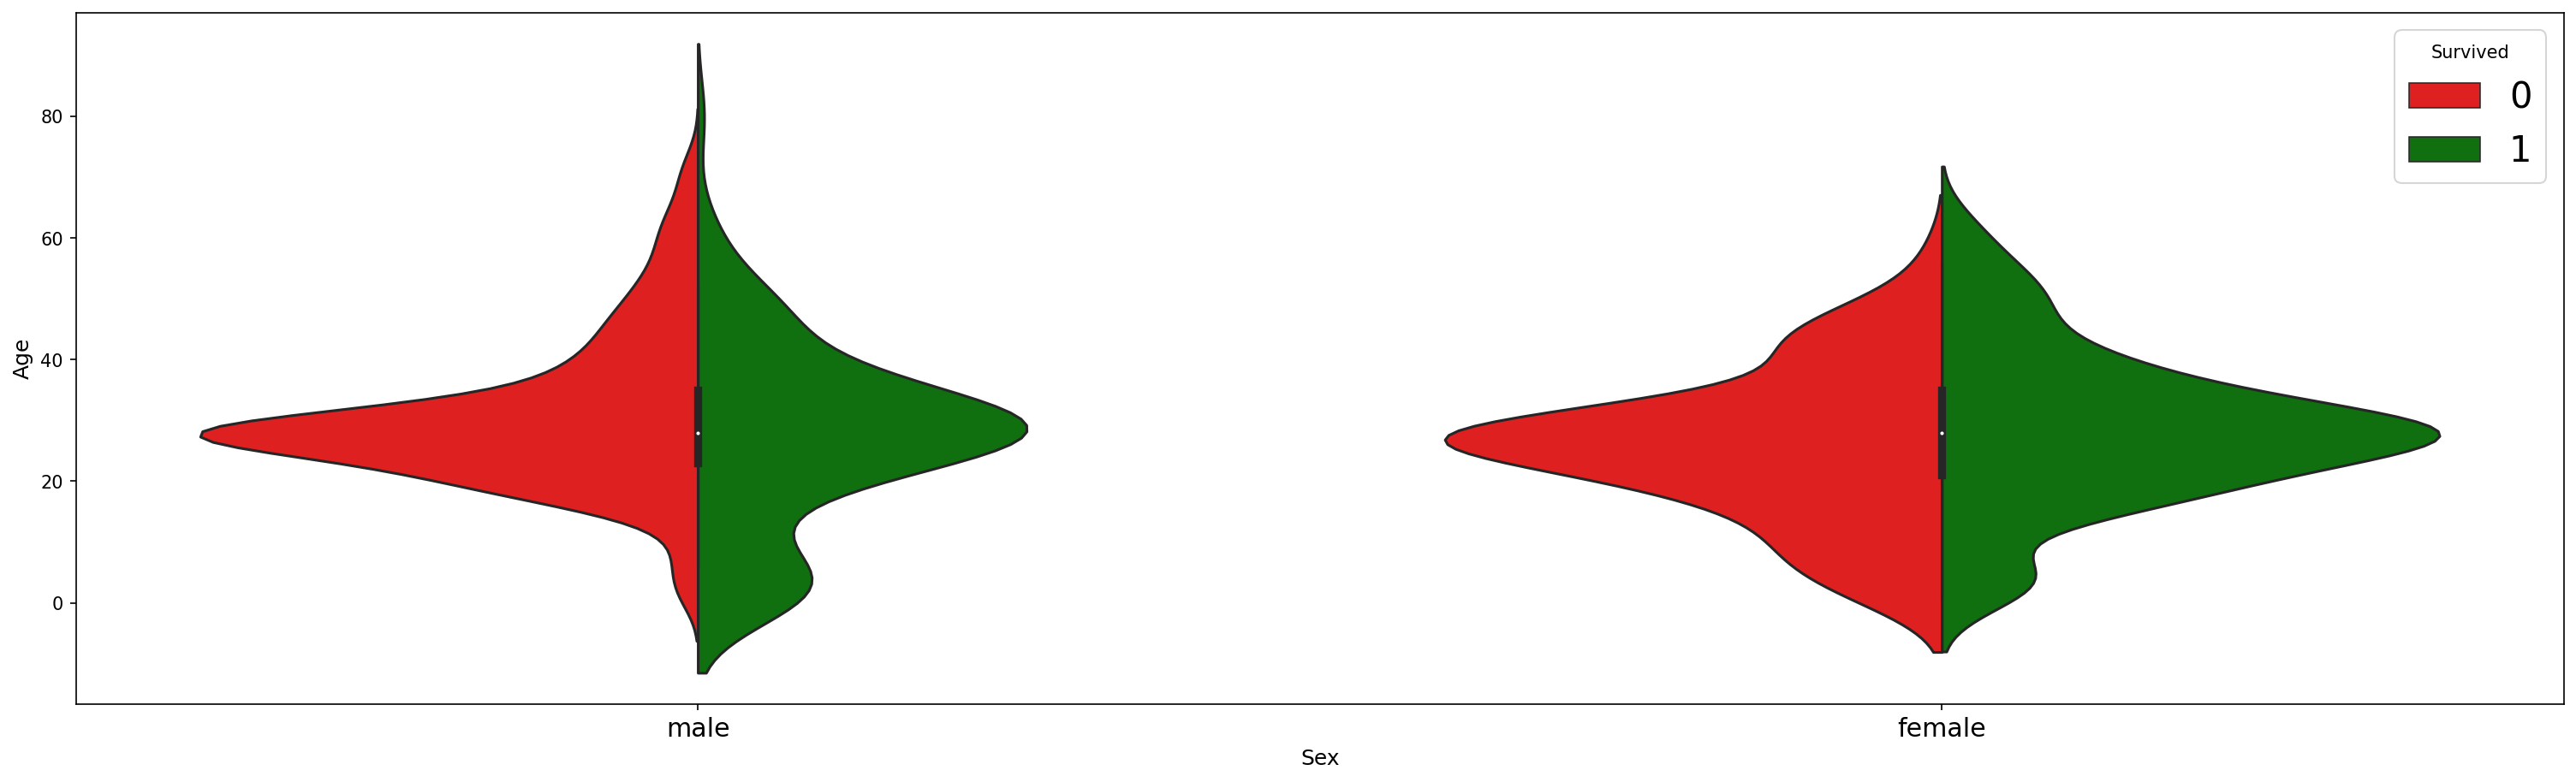

In [7]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=train_data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

#### Ticket fare
Let's now focus on the Fare ticket of each passenger and see how it could impact the survival.

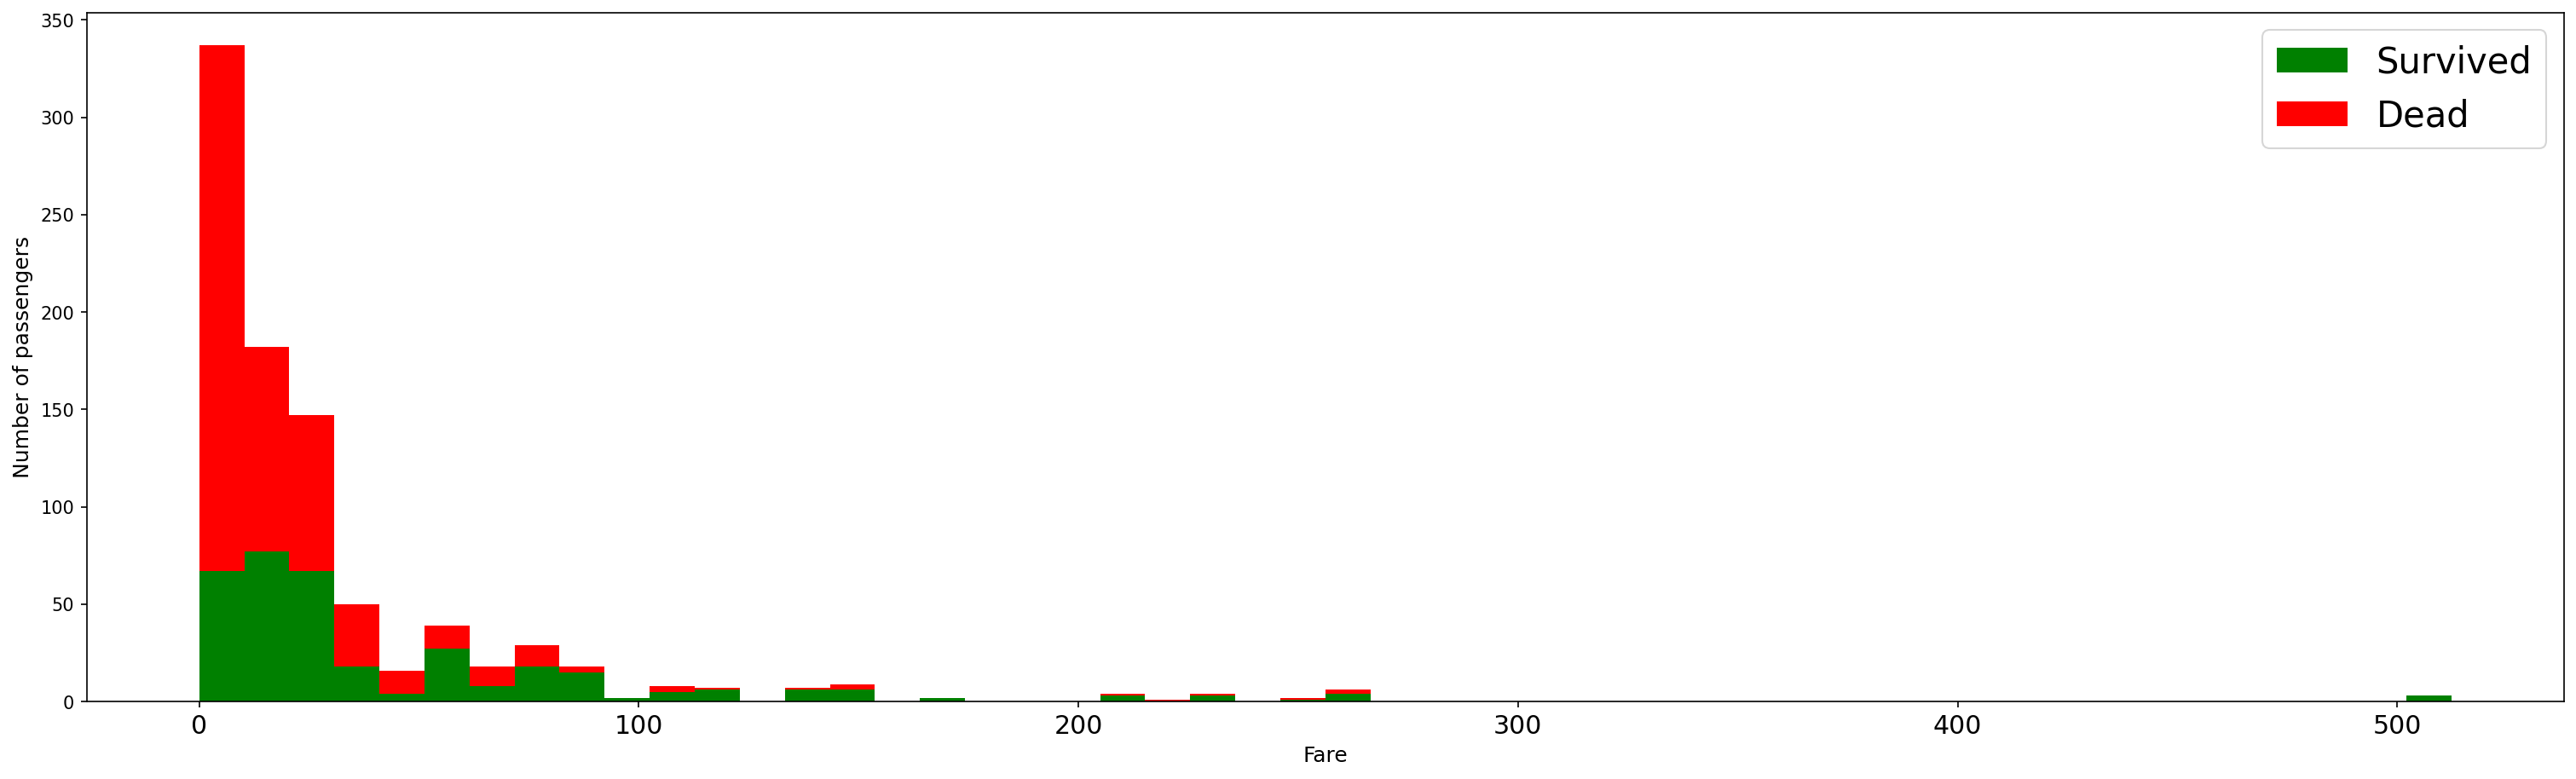

In [8]:
figure = plt.figure(figsize=(25, 7))
plt.hist([train_data[train_data['Survived'] == 1]['Fare'], train_data[train_data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

#### Age vs Fare
Ok this is nice. Let's now combine the age, the fare and the survival on a single chart.

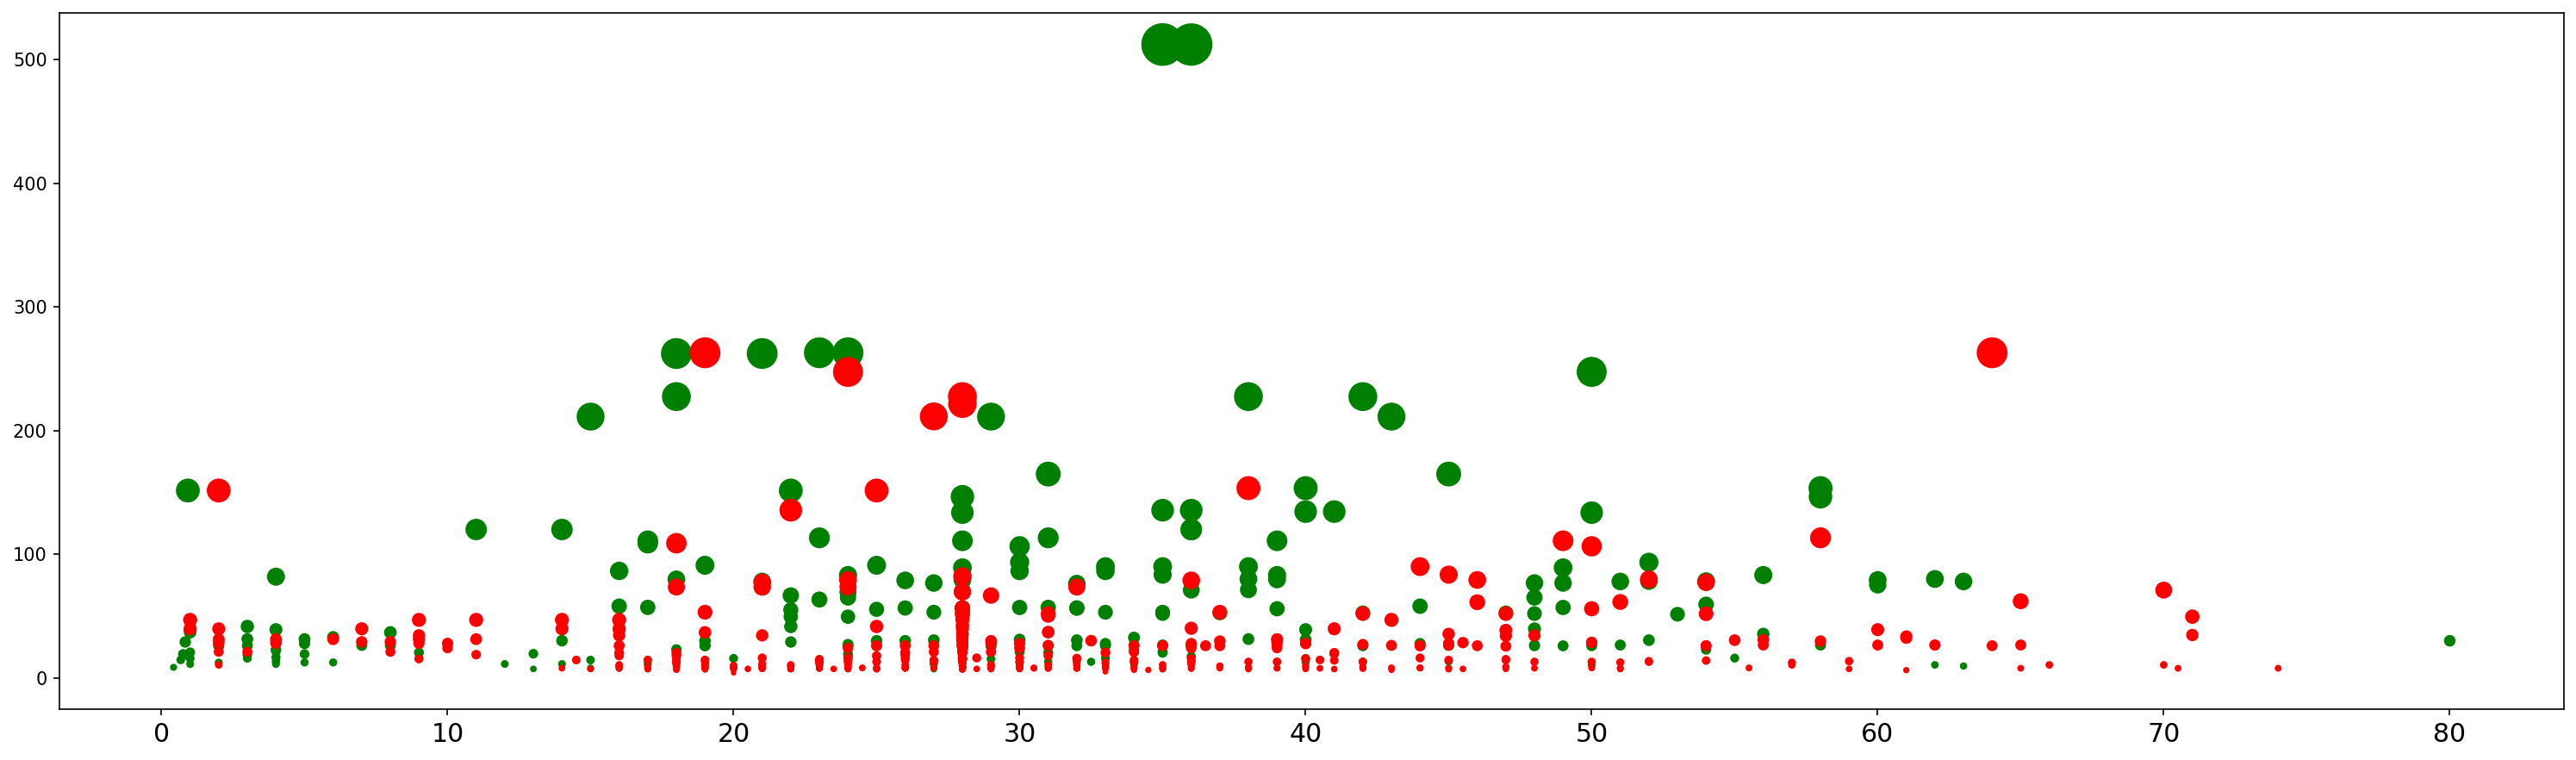

In [9]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(train_data[train_data['Survived'] == 1]['Age'], train_data[train_data['Survived'] == 1]['Fare'], 
           c='green', s=train_data[train_data['Survived'] == 1]['Fare'])
ax.scatter(train_data[train_data['Survived'] == 0]['Age'], train_data[train_data['Survived'] == 0]['Fare'], 
           c='red', s=train_data[train_data['Survived'] == 0]['Fare']);

We can observe different clusters:

1. Large green dots between x=20 and x=45: adults with the largest ticket fares
2. Small red dots between x=10 and x=45, adults from lower classes on the boat
3. Small greed dots between x=0 and x=7: these are the children that were saved

As a matter of fact, the ticket fare correlates with the class as we see it in the chart below.

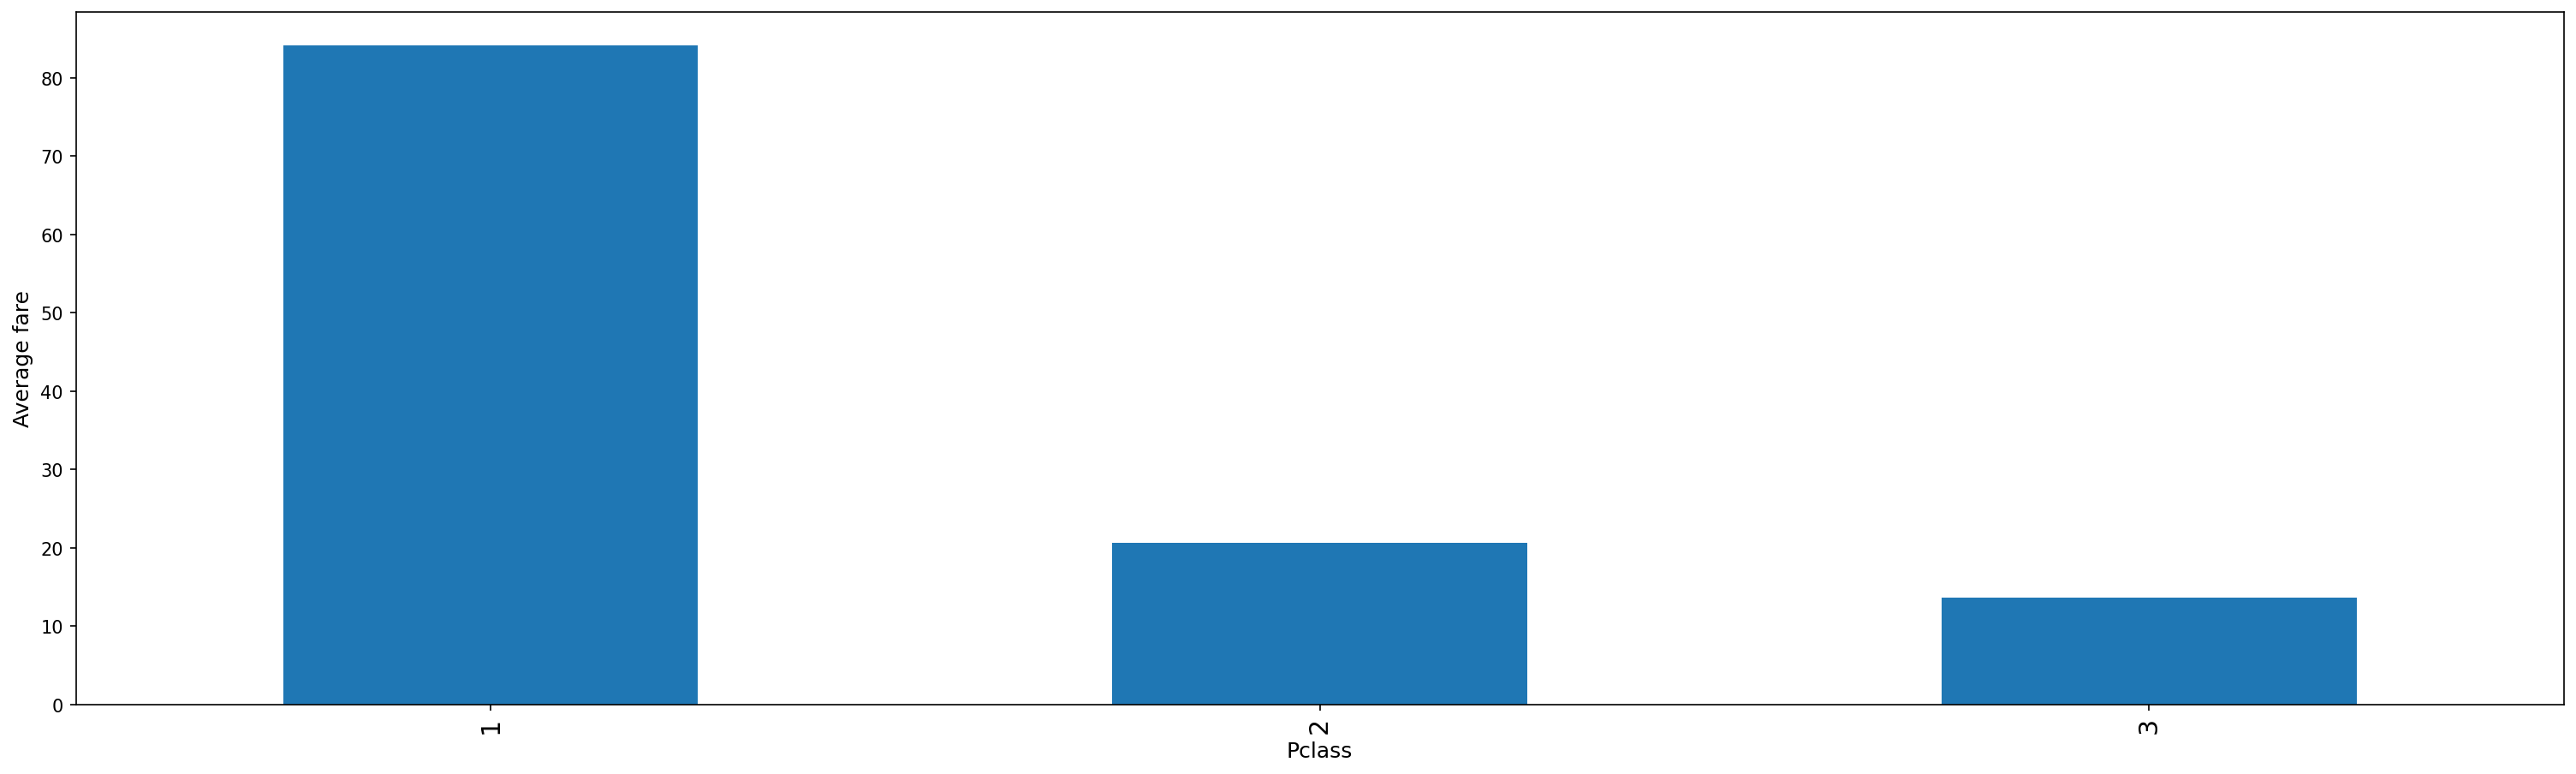

In [10]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
train_data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

#### Embarkation vs Fare
Let's now see how the embarkation side affects the survival.

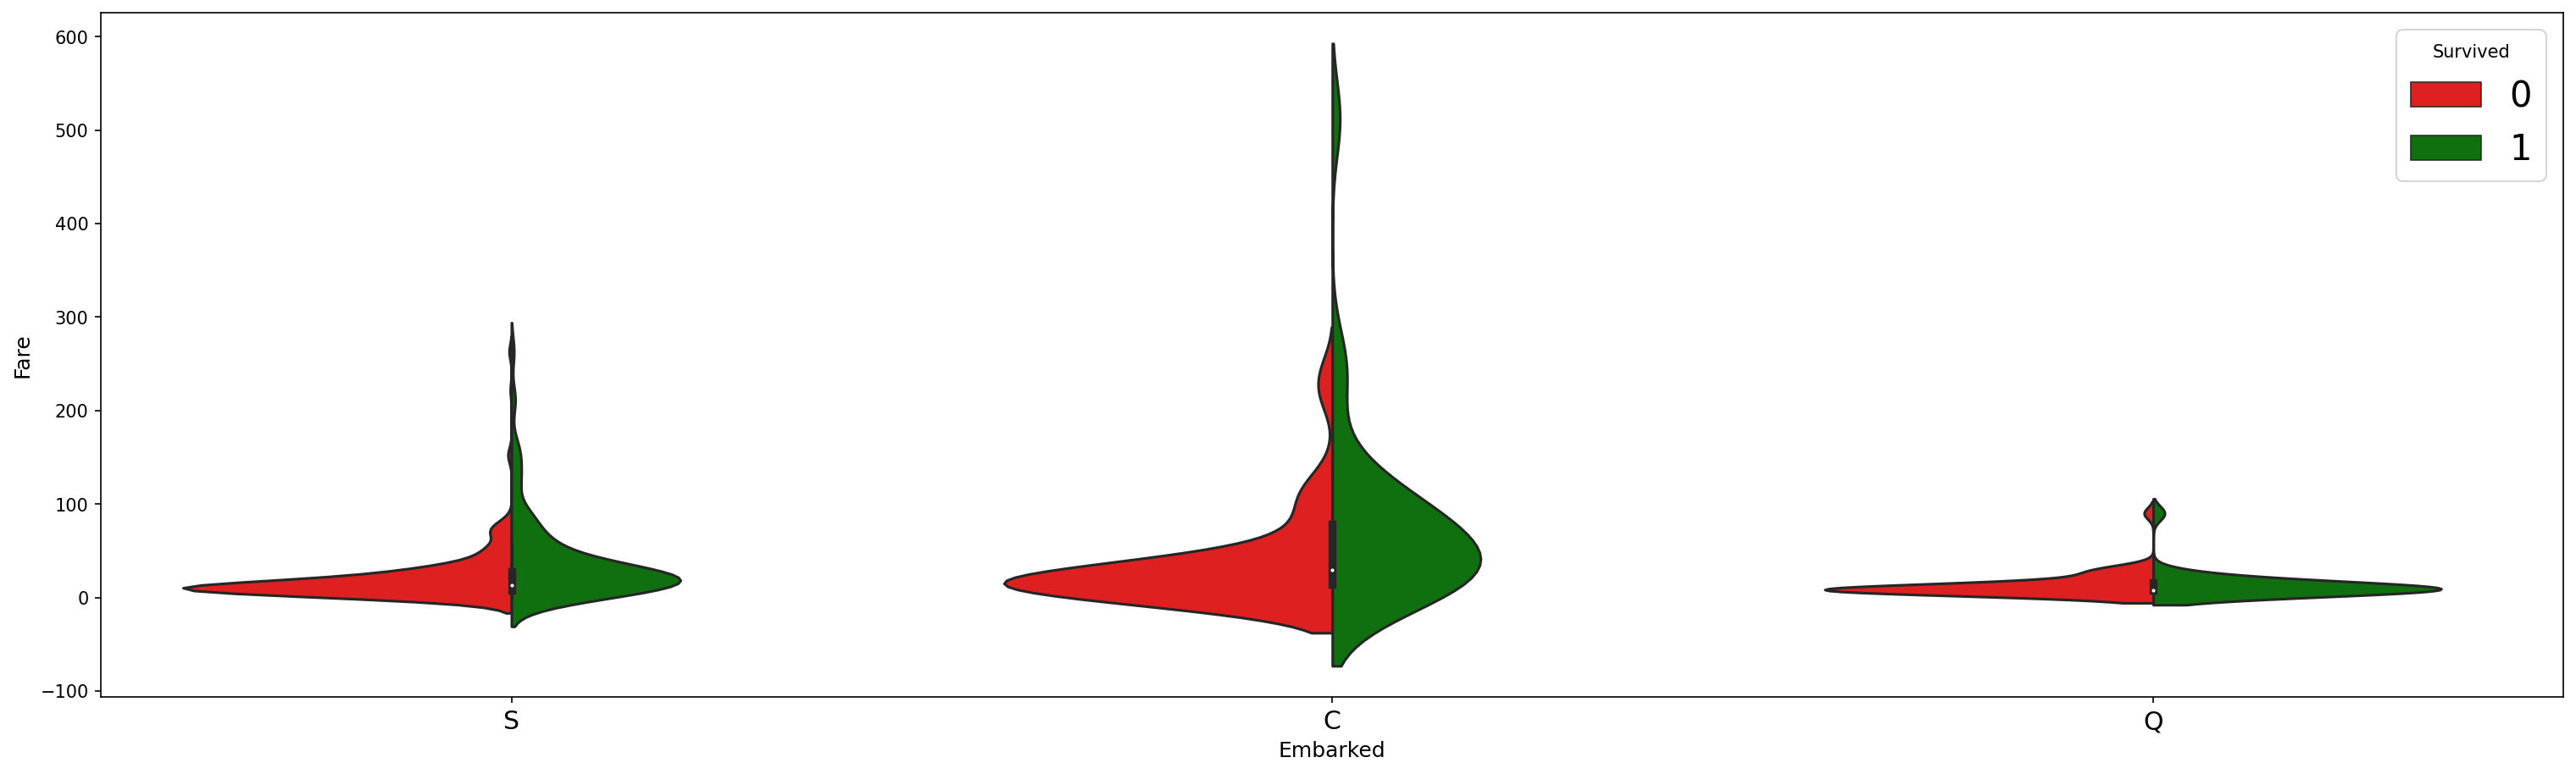

In [11]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', 
               hue='Survived', data=train_data, 
               split=True, palette={0: "r", 1: "g"});

#### Assumptions
- Women survive more than men, as depicted by the larger female green histogram
- The age conditions the survival for male passengers
    - Younger male tend to survive
    - A large number of passengers between 20 and 40 did not survive
    - The age doesn't seem to have a direct impact on the female survival
- Passengers with cheaper ticket fares are more likely to die. Put differently, passengers with more expensive tickets, and therefore a more important social status, seem to be rescued first.    
- It seems the passengers who pay the highest prices are those who survive.

## II Feature engineering 
----

#### Combine Train and Test
One trick when starting a machine learning problem is to append the training set to the test set together.

We'll engineer new features using the train set to prevent information leakage. Then we'll add these variables to the test set.
Let's load the train and test sets and append them together.

In [12]:
# but first, let's define a print function that asserts whether or not a feature has been processed.
def status(feature):
    print('Processing', feature, ': ok')

In [13]:
def get_combined_data():
    # reading train data
    train = pd.read_csv('./data/train.csv')
    
    # reading test data
    test = pd.read_csv('./data/test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    
    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined

combined = get_combined_data()

#### Processing the titles
You will notice that each name has a title in it ! This can be a simple Miss. or Mrs. but it can be sometimes something more sophisticated like Master, Sir or Dona. In that case, we might introduce an additional information about the social status by simply parsing the name and extracting the title and converting to a binary variable.

It is very important to use only train data for this feature engneering. So theoretically it can happen that some information are only available in test data.

In [14]:
titles = set()
for name in train_data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

# print(titles)
# set(['Sir', 'Major', 'the Countess', 'Don', 'Mlle', 'Capt', 'Dr', 'Lady', 'Rev', 'Mrs', 'Jonkheer', 'Master', 'Ms', 'Mr', 'Mme', 'Miss', 'Col'])

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

combined = get_titles()

Processing Title : ok


In [15]:
# This title was not encoutered in the train dataset.
# combined[combined['Title'].isnull()]

#### Processing the ages
We have seen in the first part that the Age variable was missing 177 values. This is a large number ( ~ 13% of the dataset). Simply replacing them with the mean or the median age might not be the best solution.

In [16]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


Let's create a function that fills in the missing age in combined based on these different attributes.

In [17]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined

combined = process_age()

Processing age : ok


#### Processing the names
This function drops the Name column since we won't be using it anymore because we created a Title column.

In [18]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

combined = process_names()

Processing names : ok


#### Processing the fare
This function simply replaces one missing Fare value by the mean.

In [19]:
def process_fares():
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined
combined = process_fares()


Processing fare : ok


#### Processing the embarked
This functions replaces the two missing values of Embarked with the most frequent Embarked value.

In [20]:
def process_embarked():
    global combined
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined
combined = process_embarked()

Processing embarked : ok


#### Processing Cabin
 Luckely we don't have any cabin letter in the test set that is not present in the train set.

In [21]:
def process_cabin():
    global combined    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

combined = process_cabin()

Processing cabin : ok


#### Processing the genders
This function maps the string values male and female to 1 and 0 respectively.

In [22]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

combined = process_sex()

Processing Sex : ok


#### Processing the Pclasses
This function encodes the values of Pclass (1,2,3) using a dummy encoding.

In [23]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

combined = process_pclass()

Processing Pclass : ok


#### Processing the tickets

In [24]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

combined = process_ticket()

Processing Ticket : ok


#### Processing Family
This part includes creating new variables based on the size of the family (the size is by the way, another variable we create).

This creation of new variables is done under a realistic assumption: Large families are grouped together,
hence they are more likely to get rescued than people traveling alone.

This function introduces 4 new features:

- FamilySize : the total number of relatives including the passenger (him/her)self.
- Sigleton : a boolean variable that describes families of size = 1
- SmallFamily : a boolean variable that describes families of 2 <= size <= 4
- LargeFamily : a boolean variable that describes families of 5 < size

In [25]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

combined = process_family()

Processing family : ok


## III- Modeling
----

In this part we will 
1. Break the combined dataset in train set and test set.
2. Use the train set to build a predictive model.
3. Evaluate the model using the train set.
4. Test the model using the test set and generate and output file for the submission.

### Prepare data

In [26]:
# import the useful libraries
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

To evaluate our model we'll be using a 5-fold cross validation with the accuracy since it's the metric that the competition uses in the leaderboard.

To do that, we'll define a small scoring function.

In [27]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

Recovering the train set and the test set from the combined dataset is an easy task.

In [28]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

### Feature selection
We've come up to more than 30 features so far. This number is quite large.

When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:
- It decreases redundancy among the data
- It speeds up the training process
- It reduces overfitting

Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.

In [29]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

Let's have a look at the importance of each feature.

<AxesSubplot:ylabel='feature'>

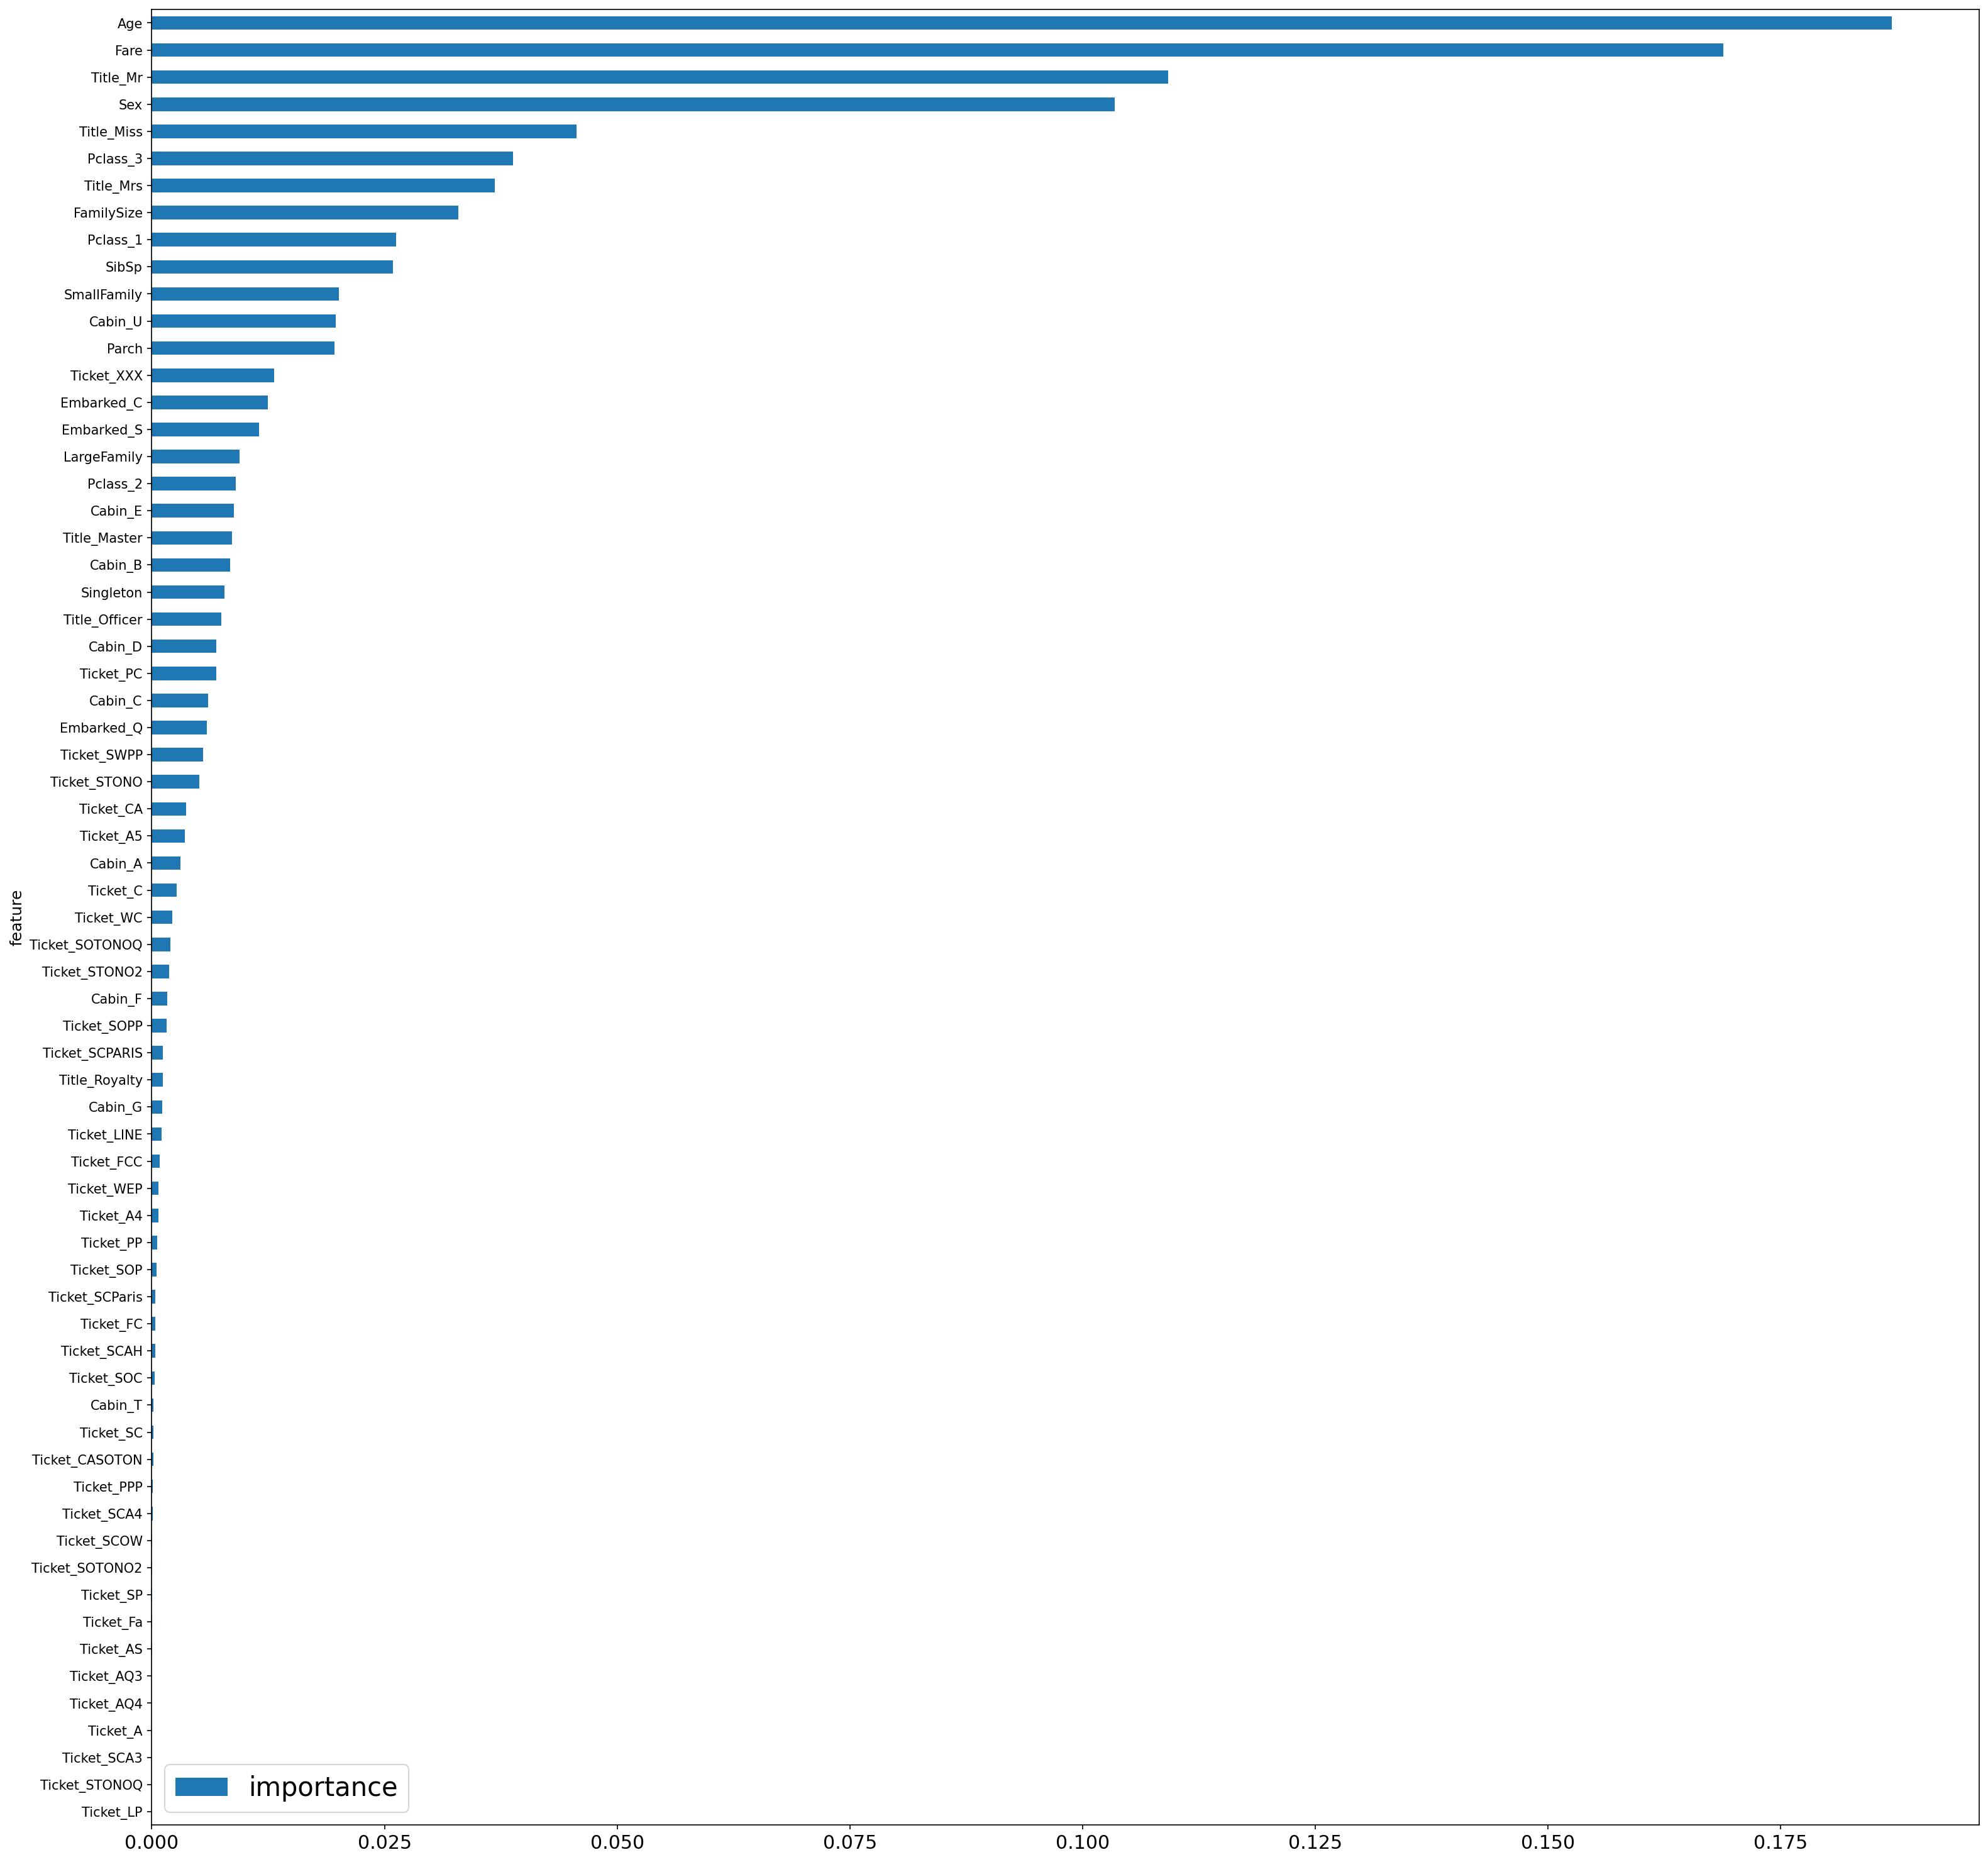

In [30]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

As you may notice, there is a great importance linked to Title_Mr, Age, Fare, and Sex.

In [31]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(f"original training data shape: {train.shape}")
print(f"reduced training data shape: {train_reduced.shape}")

test_reduced = model.transform(test)
print(f"test data shape: {test.shape}")

original training data shape: (891, 67)
reduced training data shape: (891, 13)
test data shape: (418, 67)


### Try different base models 

In [32]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8170610758897746
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.8237838177138912
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8136902893729208
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.830525390747599
****


### Hyperparameters tuning
Random Forest with full train set.

In [33]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.837266963781307
Best parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}


Now that the model is built by scanning several combinations of the hyperparameters, we can generate an output file to submit on Kaggle.

In [34]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('./data/gridsearch_rf.csv', index=False)

### Blending different models

In [35]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

predictions_df.to_csv('./data/blending_base_models.csv', index=False)

## Conclusion
-----

lesson learned:
- pandas **describe** function
- meadian vs mean (median more robust to outliers)
- pandas **groupby** function: 
    - select (mapping) feature (assume it has enum values)
    - select a grouping function f() (e.g. sum)
    - get all the other features values but splitted on the enum values
- corrolate two variables (sns.violinplot)
    - if plot is foldable (left and right are the same), feature does not have impact 
- one trick is to append the training set to the test set together.
  use only train to engineer new feature, but add it to test later
- fill in missing with:
    - **mean** or median if continue
    - **most** frequent if discret
    - **correlation** logic
- before training do a feature selection based on importance